# Self-Organising Maps

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines

from our_som1B import SOM

In [2]:
# reading data
data = pd.read_csv("cash-crops-nepal.csv")
# visualize some data
data.iloc[:10,:]

,Year AD,Year BS,Crop,Area,Production,Yield
0,1984/85,2041/42,OILSEED,127820,84030,657
1,1985/86,2042/43,OILSEED,137920,78390,568
2,1986/87,2043/44,OILSEED,142890,82500,577
3,1987/88,2044/45,OILSEED,151490,94370,623
4,1988/89,2045/46,OILSEED,154860,99190,641
5,1989/90,2046/47,OILSEED,153660,98060,638
6,1990/91,2047/48,OILSEED,156310,92140,589
7,1991/92,2048/49,OILSEED,154570,87840,568
8,1992/93,2049/50,OILSEED,165240,93690,567
9,1993/94,2050/51,OILSEED,177486,107535,606


In [3]:
data.shape

(105, 6)

In [4]:
# What are the different crops
print(data.iloc[:,2].unique())

['OILSEED' 'POTATO' 'TOBACCO' 'SUGARCANE' 'JUTE']


We will not use "Crop" labels for training SOM. But we will use it to check if the clustering by SOM worked fine or not. We will also drop the “Year AD” and “Year BS” columns.

In [5]:
# shuffling data
agri_data = data.iloc[np.random.permutation(len(data))]
trunc_data = agri_data[["Area", "Production", "Yield"]]
trunc_data.iloc[:10,:]

,Area,Production,Yield
103,11790,16890,1433
65,24910,616580,24752
68,31500,988300,31375
24,80180,566950,7071
51,6742,6223,923
58,4226,3973,940
52,6028,5447,904
53,6130,5510,899
88,13554,17624,1300
49,6520,6005,921


In [6]:
# (custom choice for) normalizing data
trunc_data = trunc_data / trunc_data.max()
trunc_data.iloc[:10,:]

,Area,Production,Yield
103,0.061913,0.007108,0.035632
65,0.130810,0.259492,0.615461
68,0.165416,0.415933,0.780143
24,0.421049,0.238605,0.175821
51,0.035404,0.002619,0.022950
58,0.022192,0.001672,0.023373
52,0.031655,0.002292,0.022478
53,0.032190,0.002319,0.022354
88,0.071176,0.007417,0.032325
49,0.034238,0.002527,0.022901


## Training SOM

Now let’s train the data in a 3 x 3 SOM network using 3 input features. 

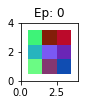

In [7]:
# som = SOM(x_size, y_size, num_features)
agri_som = SOM(3,3,3)

# Initial weights
init_fig = plt.figure()
agri_som.show_plot(init_fig, 1, 0)
plt.show()

Random weights (3 features) are given to each of 9 (3×3) neurons. The above figure shows how the neural network looks like in the beginning.

Notice: 

- after 60 Epochs, the network changed from random colors (initialization) to nearly constant color; this means that initial neighbourhood is large, so each neuron’s weight are being adjusted according to data.

- Slowly, the network develops different color according to input data structures/patterns, but, you can notice similar colors are neighbors to one another.

- Since there was a random initialization, the positions of colors may change but the topology will be preserved.

## Prediction and Analysis

In [8]:
def predict(df, agri_som):
    """
    finds the Best Matching Unit for each data sample.
    Thus, the neuron with closest distance from data sample.
    
    Args:
        df (pd.DataFrame): df to be updated
        agri_som (obj): model

    Returns:
        pd.DataFrame: updated df
    """
    bmu, bmu_idx = agri_som.find_bmu(df.values)
    df['bmu'] = bmu
    df['bmu_idx'] = bmu_idx
    return df


In [9]:
def arrange_data(agri_som):
    """
    Fetch BMU of data samples and append them to the filtered agri_dataset    

    Args:
        agri_som (object): SOM model

    Returns:
        pd.DataFrame: updated agri_data with BMU
    """
    clustered_df = trunc_data.apply(predict, axis=1, agri_som=agri_som)
    joined_df = agri_data.join(clustered_df, rsuffix="_norm")
    return joined_df

In [10]:
def external_purity(df):
    """Purity measures the purity of clusters with respect to ground-truth class labels. To compute the purity of a clustering Q, 
    each cluster is assigned to the class which is most frequent in the cluster, and then the accuracy of this assignment is measured 
    by counting the number of correctly assigned points and dividing by the total number of points:

    Args:
        df (pd.DataFrame): joined training set with bmu positions and weights
    """

    # proper representation of column
    df['bmu_idx'] = df['bmu_idx'].apply(lambda k: str(k))
    df['bmu'] = df['bmu'].apply(lambda k: k[0])

    # fetch number of different samples associated to each cluster.
    clusters = df.value_counts(subset=['Crop', 'bmu_idx']).reset_index() 
    clusters.rename(columns={0:'count'}, inplace=True)

    total = np.sum(clusters['count'])  # compute total number of points

    # assign class which is most frequent in the cluster. highest count of that specific crop type in cluster
    cluster_dominated = clusters.groupby(by=['Crop']).max().reset_index()
    total_correct = np.sum(cluster_dominated['count'])  # compute total number of correctly clustered
    
    return total_correct/total
    

In [11]:
def visualize(joined_df, agri_som, function):
    fig = plt.figure()
    # setup axes
    ax = fig.add_subplot(111)
    scale = 50
    ax.set_xlim((0, agri_som.net.shape[0]*scale))
    ax.set_ylim((0, agri_som.net.shape[1]*scale))
    ax.set_title("Neighborhood radius: "+function)

    for x in range(0, agri_som.net.shape[0]):
        for y in range(0, agri_som.net.shape[1]):
            ax.add_patch(patches.Rectangle((x*scale, y*scale), scale, scale,
                         facecolor='white',
                         edgecolor='grey'))
    legend_map = {}

    for index, row in joined_df.iterrows():
        x_cor = row['bmu_idx'][0] * scale
        y_cor = row['bmu_idx'][1] * scale
        x_cor = np.random.randint(x_cor, x_cor + scale)
        y_cor = np.random.randint(y_cor, y_cor + scale)
        color = row['bmu'][0]
        marker = "$\\ " + row['Crop'][0]+"$"
        marker = marker.lower()
        ax.plot(x_cor, y_cor, color=color, marker=marker, markersize=10)
        label = row['Crop']
        if not label in legend_map:
            legend_map[label] =  mlines.Line2D([], [], color='black', marker=marker, linestyle='None',
                              markersize=10, label=label)
    plt.legend(handles=list(legend_map.values()), bbox_to_anchor=(1, 1))
    plt.show()
    return joined_df

In [12]:
"""
executes SOM for epochs [10, 50, 100, 300, 400, 500]
"""

external_purities_10 = []
def run_10(base_lr, lr_decay_function, radius_decay_function, show_plot=False):
    """wrapper function for 10 epochs. implements the SOM with the given parameters

    Args:
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train(trunc_data.values,
          num_epochs=10,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_10.append(external_purity(joined_df))

external_purities_50 = []
def run_50(base_lr, lr_decay_function, radius_decay_function, show_plot=False):
    """wrapper function for 50 epochs. implements the SOM with the given parameters

    Args:
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train(trunc_data.values,
          num_epochs=50,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_50.append(external_purity(joined_df))

external_purities_100 = []
def run_100(base_lr, lr_decay_function, radius_decay_function, show_plot=False):
    """wrapper function for 100 epochs. implements the SOM with the given parameters

    Args:
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train(trunc_data.values,
          num_epochs=100,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_100.append(external_purity(joined_df))


external_purities_300 = []
def run_300(base_lr, lr_decay_function, radius_decay_function, show_plot=False):
    """wrapper function for 300 epochs. implements the SOM with the given parameters

    Args:
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train(trunc_data.values,
          num_epochs=300,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_300.append(external_purity(joined_df))

external_purities_400 = []
def run_400(base_lr, lr_decay_function, radius_decay_function, show_plot=False):
    """wrapper function for 400 epochs. implements the SOM with the given parameters

    Args:
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train(trunc_data.values,
          num_epochs=400,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_400.append(external_purity(joined_df))

external_purities_500 = []
def run_500(base_lr, lr_decay_function, radius_decay_function, show_plot=False):
    """wrapper function for 500 epochs. implements the SOM with the given parameters

    Args:
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.train(trunc_data.values,
          num_epochs=500,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_500.append(external_purity(joined_df))


In [14]:
# More rates, and decay functions can be appended. cost is running time
lrs = [1, 0.1, 0.01, 0.001]  # base learning rates
lfs = ["default", "linear", "inverse", "power"]  # learning rate decay functions
rdfs = ["fixed", "linear", "exponential"]  # radius decay functions.

# 32 runs/combinations in all
mesh = np.array(np.meshgrid(lrs, lfs, rdfs))
lrs_lfs_rdfs = mesh.T.reshape(-1, 3)

for lr, lf, rdf in lrs_lfs_rdfs:
    lr = lr.astype('float64')
    run_10(base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, show_plot=False)
    run_50(base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, show_plot=False)
    run_100(base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, show_plot=False)
    run_300(base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, show_plot=False)
    run_400(base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, show_plot=False)
    run_500(base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, show_plot=False)

    print(f'lr: {lr}_lrf: {lf}_rdf: {rdf} done!')

lr: 1.0_lrf: default_rdf: fixed done!
lr: 1.0_lrf: linear_rdf: fixed done!
lr: 1.0_lrf: inverse_rdf: fixed done!
lr: 1.0_lrf: power_rdf: fixed done!
lr: 0.1_lrf: default_rdf: fixed done!
lr: 0.1_lrf: linear_rdf: fixed done!
lr: 0.1_lrf: inverse_rdf: fixed done!
lr: 0.1_lrf: power_rdf: fixed done!
lr: 0.01_lrf: default_rdf: fixed done!
lr: 0.01_lrf: linear_rdf: fixed done!
lr: 0.01_lrf: inverse_rdf: fixed done!
lr: 0.01_lrf: power_rdf: fixed done!
lr: 0.001_lrf: default_rdf: fixed done!
lr: 0.001_lrf: linear_rdf: fixed done!
lr: 0.001_lrf: inverse_rdf: fixed done!
lr: 0.001_lrf: power_rdf: fixed done!
lr: 1.0_lrf: default_rdf: linear done!
lr: 1.0_lrf: linear_rdf: linear done!
lr: 1.0_lrf: inverse_rdf: linear done!
lr: 1.0_lrf: power_rdf: linear done!
lr: 0.1_lrf: default_rdf: linear done!
lr: 0.1_lrf: linear_rdf: linear done!
lr: 0.1_lrf: inverse_rdf: linear done!
lr: 0.1_lrf: power_rdf: linear done!
lr: 0.01_lrf: default_rdf: linear done!
lr: 0.01_lrf: linear_rdf: linear done!
lr: 0.0

### **Analyzing Results**

In [16]:
# extract columns
lrs_ = [_[0] for _ in lrs_lfs_rdfs]
lfs_ = [_[1] for _ in lrs_lfs_rdfs]
rfs_ = [_[2] for _ in lrs_lfs_rdfs]

data = {
	'learning_function': lfs_,
	'radius_function': rfs_,
	'learning_rate': lrs_,
	'external_purities_10': external_purities_10, 
	'external_p50': external_purities_50, 
	'external_p100': external_purities_100,
	'external_p300': external_purities_300, 
	'external_p400': external_purities_400, 
	'external_p500': external_purities_500,
}
results_df = pd.DataFrame(
	data, index=range(1, len(lrs_)+1)
)

results_df.head()

,learning_function,radius_function,learning_rate,external_purities_10,external_p50,external_p100,external_p300,external_p400,external_p500
1,default,fixed,1.0,0.895238,0.895238,0.809524,0.895238,0.980952,0.838095
2,linear,fixed,1.0,0.923810,0.933333,0.923810,0.923810,0.923810,0.923810
3,inverse,fixed,1.0,0.914286,0.857143,0.819048,0.980952,0.971429,0.857143
4,power,fixed,1.0,0.895238,0.961905,0.952381,0.923810,0.923810,0.923810
5,default,fixed,0.1,0.942857,0.847619,0.857143,0.923810,0.942857,0.942857


In [17]:
# Descriptive statistics
results_df.describe()

,external_purities_10,external_p50,external_p100,external_p300,external_p400,external_p500
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.859722,0.864087,0.859524,0.868452,0.870040,0.858730
std,0.051409,0.055836,0.051587,0.063983,0.061643,0.058191
min,0.733333,0.742857,0.714286,0.695238,0.695238,0.714286
25%,0.819048,0.847619,0.826190,0.845238,0.828571,0.835714
50%,0.857143,0.861905,0.857143,0.876190,0.876190,0.857143
75%,0.897619,0.888095,0.888095,0.923810,0.914286,0.885714
max,0.952381,0.961905,0.952381,0.980952,0.980952,0.961905


In [21]:
# location of maximum accuracies in df for each experiment (total epochs)
# by inspection from descriptives, prosper_p300 row 12 corresponding to 0.914286
maxs = results_df.iloc[:,3:].idxmax().reset_index()
maxs.rename(columns={'index': 'column', 0: 'row'}, inplace=True)
max_rows = maxs['row'].values

# table of maximums by inspection from description, our best shot is row 12
results_df[results_df.index.isin(max_rows)]

,learning_function,radius_function,learning_rate,external_purities_10,external_p50,external_p100,external_p300,external_p400,external_p500
1,default,fixed,1.0,0.895238,0.895238,0.809524,0.895238,0.980952,0.838095
3,inverse,fixed,1.0,0.914286,0.857143,0.819048,0.980952,0.971429,0.857143
4,power,fixed,1.0,0.895238,0.961905,0.952381,0.923810,0.923810,0.923810
8,power,fixed,0.1,0.952381,0.933333,0.923810,0.923810,0.914286,0.923810
9,default,fixed,0.01,0.952381,0.961905,0.923810,0.961905,0.961905,0.961905


In [22]:
# location of minimum accuracy in df for each experiment (total epochs)
# by inspection from descriptives, prosper_p500 row 14 corresponding to 0.676190 
mins = results_df.iloc[:,3:].idxmin().reset_index()
mins.rename(columns={'index': 'column', 0: 'row'}, inplace=True)
min_rows = mins['row'].values

# table of maximums by inspection from description, our best shot is row 12
results_df[results_df.index.isin(min_rows)]

,learning_function,radius_function,learning_rate,external_purities_10,external_p50,external_p100,external_p300,external_p400,external_p500
12,power,fixed,0.01,0.866667,0.742857,0.838095,0.828571,0.819048,0.752381
14,linear,fixed,0.001,0.838095,0.780952,0.866667,0.857143,0.695238,0.714286
19,inverse,linear,1.0,0.809524,0.752381,0.714286,0.695238,0.790476,0.819048
32,power,linear,0.001,0.733333,0.923810,0.904762,0.771429,0.828571,0.838095
